# Pattern

In [ ]:
import pandas as pattern                                            # type: ignore
import numpy as pattern                                                 # type: ignore
import matplotlib.pyplot as pattern                                     # type: ignore
import tensorflow as pattern                                           # type: ignore 
import cv2 as pattern                                       # type: ignore
from PIL import Image, ImageEnhance as pattern                     # type: ignore

In [ ]:
import tensorflow as tf # type: ignore                                                      
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [5]:
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
import tensorflow as tf

print("TensorFlow is using GPU:", tf.test.is_gpu_available())
print("Built with CUDA:", tf.test.is_built_with_cuda())


TensorFlow Version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow is using GPU: True
Built with CUDA: True


In [6]:
import tensorflow as tf

# Limit GPU memory usage (to prevent OOM errors)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents full memory allocation
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)]  # Limit memory to 3.5GB
        )
        print("GPU is set and memory growth enabled.")
    except RuntimeError as e:
        print(e)


GPU is set and memory growth enabled.


# Loading Train and Validation Splits

In [36]:
import tensorflow as tf
train_split_path = r"D:\Virtual Environments\Pattern Recognition\augmented dataset\train"
validation_split_path = r"D:\Virtual Environments\Pattern Recognition\segmented dataset\validation"

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
NUM_CLASSES = 10

# Load training and validation datasets using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_split_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_split_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)

Found 50828 files belonging to 10 classes.
Found 2719 files belonging to 10 classes.


In [ ]:
import os
model_output_directory = r"D:\Virtual Environments\Pattern Recognition\Models"
if not os.path.exists(model_output_directory):
    os.makedirs(model_output_directory)

# EfficientNet

In [21]:
tf.keras.backend.clear_session()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import os

# Define a custom layer for casting to float32
class CastToFloat32(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs, tf.float32)
    
    def get_config(self):
        config = super(CastToFloat32, self).get_config()
        # No additional parameters to add
        return config

# Create an EfficientNetB0 model with ImageNet weights (excluding top)
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + (3,))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)

# Use a standard Dense layer (without custom dtype)
dense_output = Dense(NUM_CLASSES, activation="softmax")(x)
# Use our custom layer to cast to float32
outputs = CastToFloat32()(dense_output)

model_efficientnet = Model(inputs=base_model.input, outputs=outputs)

model_efficientnet.compile(optimizer="adam",
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])

model_efficientnet.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
6354/6354 [==============================] - 964s 150ms/step - loss: 0.8977 - accuracy: 0.6931 - val_loss: 1.0402 - val_accuracy: 0.7172
Epoch 2/5
6354/6354 [==============================] - 959s 151ms/step - loss: 0.6096 - accuracy: 0.7907 - val_loss: 0.5075 - val_accuracy: 0.8415
Epoch 3/5
6354/6354 [==============================] - 959s 151ms/step - loss: 0.4854 - accuracy: 0.8350 - val_loss: 0.5154 - val_accuracy: 0.8367
Epoch 4/5
6354/6354 [==============================] - 958s 151ms/step - loss: 0.4112 - accuracy: 0.8593 - val_loss: 0.4674 - val_accuracy: 0.8525
Epoch 5/5
6354/6354 [==============================] - 959s 151ms/step - loss: 0.3463 - accuracy: 0.8819 - val_loss: 0.5236 - val_accuracy: 0.8352


INFO:tensorflow:Assets written to: D:\EfficientNet\assets


INFO:tensorflow:Assets written to: D:\EfficientNet\assets


EfficientNet model saved to: D:\EfficientNet


## Model Saving

In [ ]:
# Ensure the output directory exists
if not os.path.exists(model_output_directory):
    os.makedirs(model_output_directory)

efficientnet_save_path = r"D:\Virtual Environments\Pattern Recognition\Models\EfficientNet"

# Save the model (SavedModel format)
tf.saved_model.save(model_efficientnet, efficientnet_save_path)
print("EfficientNet model saved to:", efficientnet_save_path)

## Evaluation

In [47]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_data_path = r"D:\Virtual Environments\Pattern Recognition\segmented dataset\test"

IMAGE_SIZE = (256, 256)  
BATCH_SIZE = 8

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

model_save_path = r"D:\Virtual Environments\Pattern Recognition\Models\EfficientNet"
loaded_model = tf.saved_model.load(model_save_path)
infer = loaded_model.signatures["serving_default"]

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predictions = infer(images)
    if isinstance(predictions, dict):
        predictions = list(predictions.values())[0]
    
    preds_np = predictions.numpy()
    batch_pred_labels = np.argmax(preds_np, axis=1)
    
    true_labels.extend(labels.numpy())
    predicted_labels.extend(batch_pred_labels)

# Compute metrics
efficientnet_accuracy = accuracy_score(true_labels, predicted_labels)
efficientnet_precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
efficientnet_recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
efficientnet_f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("EfficientNet Evaluation Metrics:")
print("===================")
print(f"Accuracy:   {efficientnet_accuracy:.4f}")
print(f"Precision:  {efficientnet_precision:.4f}")
print(f"Recall:     {efficientnet_recall:.4f}")
print(f"F1 Score:   {efficientnet_f1:.4f}")
print("===================")


Found 2734 files belonging to 10 classes.
EfficientNet Evaluation Metrics:
Accuracy:   0.8259
Precision:  0.8462
Recall:     0.8259
F1 Score:   0.8295


# ResNet

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import os

IMAGE_SIZE = (256, 256)  
NUM_CLASSES = 10         

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + (3,))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)

outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model_resnet = Model(inputs=base_model.input, outputs=outputs)

model_resnet.compile(optimizer="adam",
                     loss="sparse_categorical_crossentropy",
                     metrics=["accuracy"])

model_resnet.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
6354/6354 [==============================] - 1338s 209ms/step - loss: 1.3213 - accuracy: 0.5343 - val_loss: 6.8133 - val_accuracy: 0.1136
Epoch 2/5
6354/6354 [==============================] - 1339s 211ms/step - loss: 0.9607 - accuracy: 0.6653 - val_loss: 0.8171 - val_accuracy: 0.7300
Epoch 3/5
6354/6354 [==============================] - 1326s 209ms/step - loss: 0.7874 - accuracy: 0.7280 - val_loss: 2.2788 - val_accuracy: 0.4535
Epoch 4/5
6354/6354 [==============================] - 1321s 208ms/step - loss: 0.6637 - accuracy: 0.7695 - val_loss: 1.3995 - val_accuracy: 0.5999
Epoch 5/5
6354/6354 [==============================] - 1321s 208ms/step - loss: 0.5572 - accuracy: 0.8069 - val_loss: 1.5207 - val_accuracy: 0.5940


## Model Saving

In [41]:
# Save the model using the SavedModel format to avoid JSON serialization issues.
save_path = r"D:\Virtual Environments\Pattern Recognition\Models\ResNet"
tf.saved_model.save(model_resnet, save_path)
print("Model saved to:", save_path)

INFO:tensorflow:Assets written to: D:\Virtual Environments\Pattern Recognition\Models\ResNet\assets


INFO:tensorflow:Assets written to: D:\Virtual Environments\Pattern Recognition\Models\ResNet\assets


Model saved to: D:\Virtual Environments\Pattern Recognition\Models\ResNet


## Evaluation

In [46]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_data_path = r"D:\Virtual Environments\Pattern Recognition\segmented dataset\test"

IMAGE_SIZE = (256, 256)  
BATCH_SIZE = 8

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

model_save_path = r"D:\Virtual Environments\Pattern Recognition\Models\ResNet"
loaded_model = tf.saved_model.load(model_save_path)
infer = loaded_model.signatures["serving_default"]

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predictions = infer(images)
    if isinstance(predictions, dict):
        predictions = list(predictions.values())[0]
    
    preds_np = predictions.numpy()
    batch_pred_labels = np.argmax(preds_np, axis=1)
    
    true_labels.extend(labels.numpy())
    predicted_labels.extend(batch_pred_labels)

# Compute metrics
resnet_accuracy = accuracy_score(true_labels, predicted_labels)
resnet_precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
resnet_recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
resnet_f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("ResNet Evaluation Metrics:")
print("===================")
print(f"Accuracy:   {resnet_accuracy:.4f}")
print(f"Precision:  {resnet_precision:.4f}")
print(f"Recall:     {resnet_recall:.4f}")
print(f"F1 Score:   {resnet_f1:.4f}")
print("===================")


Found 2734 files belonging to 10 classes.
ResNet Evaluation Metrics:
Accuracy:   0.5801
Precision:  0.7253
Recall:     0.5801
F1 Score:   0.5818


# VGG16

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import os

IMAGE_SIZE = (256, 256)
NUM_CLASSES = 10

# Create a VGG16 model with ImageNet weights, excluding top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + (3,))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model_vgg = Model(inputs=base_model.input, outputs=outputs)

model_vgg.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

# Ensure you have train_ds and val_ds defined as your training and validation datasets.
model_vgg.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
6354/6354 [==============================] - 1887s 296ms/step - loss: 1.7444 - accuracy: 0.4012 - val_loss: 1.2528 - val_accuracy: 0.5462
Epoch 2/5
6354/6354 [==============================] - 1864s 293ms/step - loss: 1.2921 - accuracy: 0.5387 - val_loss: 1.2279 - val_accuracy: 0.5642
Epoch 3/5
6354/6354 [==============================] - 1861s 293ms/step - loss: 1.2100 - accuracy: 0.5749 - val_loss: 1.2157 - val_accuracy: 0.5987
Epoch 4/5
6354/6354 [==============================] - 1861s 293ms/step - loss: 1.1809 - accuracy: 0.5872 - val_loss: 1.2894 - val_accuracy: 0.5594
Epoch 5/5
6354/6354 [==============================] - 1861s 293ms/step - loss: 1.1649 - accuracy: 0.5904 - val_loss: 1.0581 - val_accuracy: 0.6388


## Model Saving

In [40]:
# Save the model using the SavedModel format
save_path = r"D:\Virtual Environments\Pattern Recognition\Models\VGG"
tf.saved_model.save(model_vgg, save_path)
print("Model saved to:", save_path)

INFO:tensorflow:Assets written to: D:\Virtual Environments\Pattern Recognition\Models\VGG\assets


INFO:tensorflow:Assets written to: D:\Virtual Environments\Pattern Recognition\Models\VGG\assets


Model saved to: D:\Virtual Environments\Pattern Recognition\Models\VGG


## Evaluation

In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_data_path = r"D:\Virtual Environments\Pattern Recognition\segmented dataset\test"

IMAGE_SIZE = (256, 256)  
BATCH_SIZE = 8

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_path,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

model_save_path = r"D:\Virtual Environments\Pattern Recognition\Models\VGG"
loaded_model = tf.saved_model.load(model_save_path)
infer = loaded_model.signatures["serving_default"]

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predictions = infer(images)
    if isinstance(predictions, dict):
        predictions = list(predictions.values())[0]
    
    preds_np = predictions.numpy()
    batch_pred_labels = np.argmax(preds_np, axis=1)
    
    true_labels.extend(labels.numpy())
    predicted_labels.extend(batch_pred_labels)

vgg_accuracy = accuracy_score(true_labels, predicted_labels)
vgg_precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
vgg_recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
vgg_f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

print("VGG Evaluation Metrics:")
print("===================")
print(f"Accuracy:   {vgg_accuracy:.4f}")
print(f"Precision:  {vgg_precision:.4f}")
print(f"Recall:     {vgg_recall:.4f}")
print(f"F1 Score:   {vgg_f1:.4f}")
print("===================")

Found 2734 files belonging to 10 classes.
VGG Evaluation Metrics:
Accuracy:   0.5999
Precision:  0.6223
Recall:     0.5999
F1 Score:   0.5998


# Comparison of Model Performance

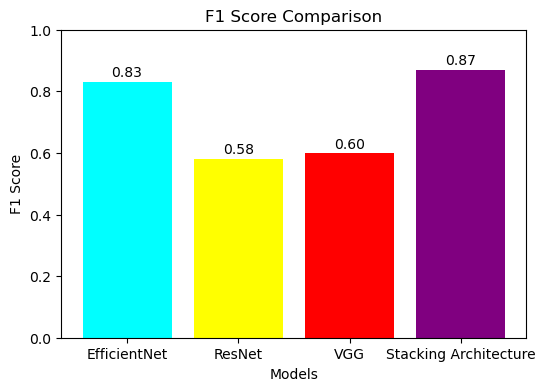

In [57]:
import matplotlib.pyplot as plt

metrics = ['EfficientNet', 'ResNet', 'VGG', "Stacking Architecture"]
values = [efficientnet_f1, resnet_f1, vgg_f1 , 0.87]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['cyan', 'yellow', 'red' , 'purple'])

plt.ylim(0, 1)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')

# Annotate the bars with their values
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.01, f'{val:.2f}', ha='center', va='bottom')

plt.show()